In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt
from tqdm import tqdm
market_data = pd.read_parquet('data/US/test_mkt_data.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/test_adv_table.pq')
market_data.dropna().sample(5)

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2021-08-03,JEF,2021-08-03,33.7723,33.8873,32.5629,33.7123,29.6365,1010144,2.435885e+12
2023-12-13,FTV,2023-12-13,71.1800,71.5800,70.7400,71.1900,71.1225,3299168,3.078823e+12
2021-07-06,META,2021-07-06,356.5000,358.7900,349.1800,352.7800,352.4061,13488460,2.351417e+12
2020-07-21,SAF,2020-07-21,24.1500,24.5000,24.1500,24.2100,22.4035,6809,1.658946e+12
2023-10-04,DOW,2023-10-04,51.4800,51.4800,50.2050,51.1100,49.7907,4727292,2.700424e+12


In [18]:
market_features = pd.read_parquet('data/US/market_features.pq')
R = market_features['daily_returns'].unstack()

In [25]:
import pandas_ta as ta 

close = market_data['close'].unstack().reindex_like(P)
rsi = []
for ticker in close.columns.tolist():
    try : 
        rsi_ticker = ta.rsi(close[ticker],length=10)
        rsi_ticker= pd.DataFrame(rsi_ticker)
        rsi_ticker.columns = [ticker]
        rsi.append(rsi_ticker[ticker])
    except : 
        print(ticker)
        pass

In [26]:
rsi = pd.concat(rsi,axis=1)

In [27]:
rsi_50 = rsi - 50
volume = market_data['volume'].unstack().reindex_like(P)
tsrank_volume = volume.rolling(10).rank(pct=True,ascending=True)

In [28]:
mean_5 = tsrank_volume.rolling(5).mean()

C:\Users\marti\AppData\Local\Temp\ipykernel_27228\2620487042.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center).droplevel(axis=1,level=0)


Sharpe                     1.3
Daily Turnover (%)        53.5
biais (bp)                 2.6
Sharpe since 2022          0.6
biais  since 2022 (bp)     1.4
dtype: float64

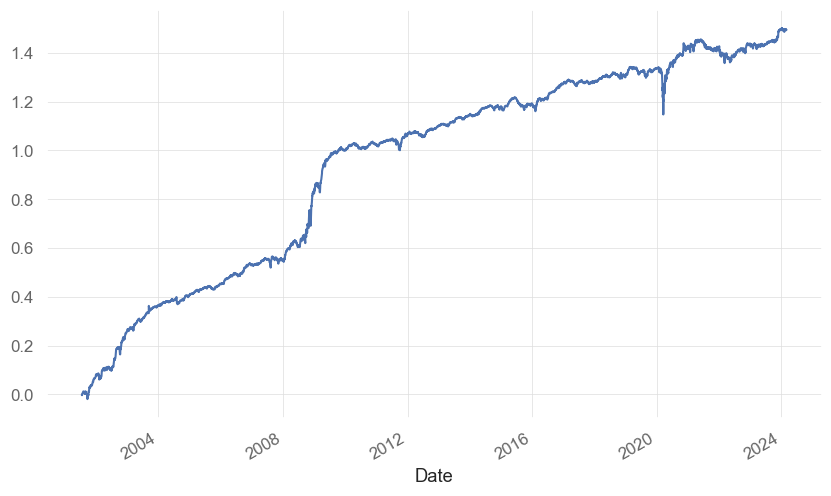

In [29]:
signal = (rsi_50/ mean_5)[P].ffill()[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.25] =None
signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center).droplevel(axis=1,level=0)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).dropna(axis=0,how = 'all').sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,
           'Daily Turnover (%)':turnover *100,
           'biais (bp)':PNL.mean()*1e4,
           'Sharpe since 2022' : sharpe(PNL.loc['2022':]),
           'biais  since 2022 (bp)':PNL.loc['2022':].mean()*1e4}).round(1)

In [33]:
log_ret = np.log(1+R.clip(-0.99,0.99))
std_20 = log_ret.rolling(20).std()
mult = close * volume 
mult_mult = log_ret * mult
div = mult / std_20
csrank = div.rank(axis=1,pct=True,ascending=True)
mean_12 = csrank.rolling(252).mean()

C:\Users\marti\AppData\Local\Temp\ipykernel_27228\3398116411.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center).droplevel(axis=1,level=0)


Sharpe                    0.3
Daily Turnover (%)        1.1
biais (bp)                0.4
Sharpe since 2022         0.2
biais  since 2022 (bp)    0.4
dtype: float64

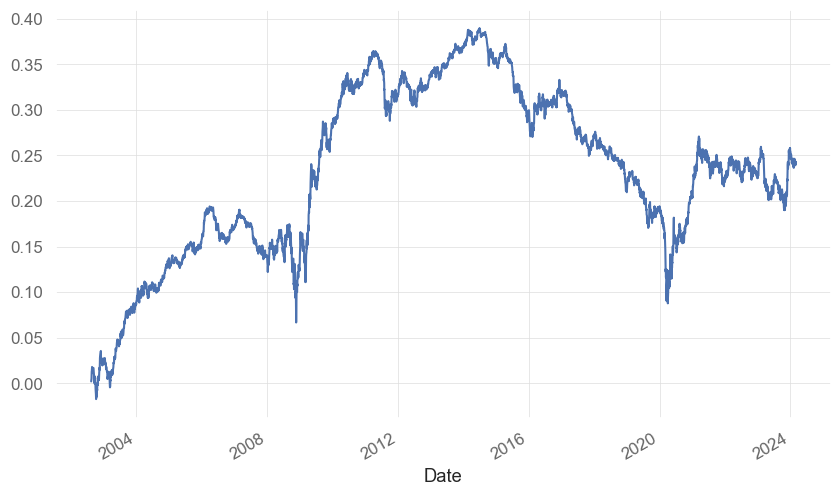

In [34]:
signal = mean_12[P].ffill()[P].rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal[signal.abs()<0.25] =None
signal = signal[P].groupby(GICS['gicgrp'],axis=1).apply(center).droplevel(axis=1,level=0)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).dropna(axis=0,how = 'all').sum(1)
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,
           'Daily Turnover (%)':turnover *100,
           'biais (bp)':PNL.mean()*1e4,
           'Sharpe since 2022' : sharpe(PNL.loc['2022':]),
           'biais  since 2022 (bp)':PNL.loc['2022':].mean()*1e4}).round(1)